<a href="https://colab.research.google.com/github/JonFillip/House_Prices_Prediction/blob/main/AIEcosystem_ASS3_XGClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install cbor
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for cbor: filename=cbor-1.0.0-cp310-cp310-linux_x86_64.whl size=57671 sha256=20dda902d5509422206e337f4cd68d13752af26d64fe388733a78a548303da15
  Stored in directory: /root/.cache/pip/wheels/85/df/c9/b39e40eccaf76dbd218556639a6dc81562226f4c6a64902c85
Successfully built cbor
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import pandas as pd
import cbor
from google.colab import drive, files
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [3]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
PATH = "/content/drive/My Drive/Colab Notebooks/ai_ecosystems_data_ass3/"   

def fetch_xray_data(path=PATH):
  if os.path.exists(PATH):
    print('directory already exists')
  else:
    os.makedirs(PATH)
    upload = files.upload()

  # change directory to 'grape'
  %cd /content/drive/My Drive/Colab Notebooks/ai_ecosystems_data_ass3/


fetch_xray_data()

directory already exists
/content/drive/My Drive/Colab Notebooks/ai_ecosystems_data_ass3


In [ ]:
def print_cbor_file_content(filepath):
    with open(filepath, 'rb') as f:
        data = cbor.load(f)
    print(data)

cbor_file_path = PATH + 'john_training_data/JA_CL_R1_LW.3topu6jr.ingestion-76b9544989-76nps.cbor'
print_cbor_file_content(cbor_file_path)

In [10]:
# Method: get_instrument_name
# Inputs: df:Table
# Output: res: dict
def get_instrument_name(code):
    instrument_map = {
        'REC': 'Recorder',
        'GUI': 'Guitar',
        'ACC': 'Accordion',
        'VL': 'Violin',
        'CL': 'Cello',
        'KEY': 'Keyboard',
        'FLU': 'Flute',
        'CON': 'Concertina',
    }
    code = code.rstrip('_')  # Remove the trailing underscore
    instrument_name = instrument_map.get(code, 'Unknown')
    if instrument_name == 'Unknown':
        print(f"Unknown instrument code: {code}")
    return instrument_name


In [11]:
# Method: load_cbor_file
# Inputs: data:Text
# Output: df:Table
def load_cbor_file(filepath):
    with open(filepath, 'rb') as f:
        data = cbor.load(f)

    payload = data['payload']
    values = payload['values']
    df = pd.DataFrame(values, columns=['x', 'y', 'z'])
    filename = os.path.splitext(os.path.basename(filepath))[0]
    df['filename'] = filename
    df['instrument'] = df['filename'].str[3:6].apply(get_instrument_name)

    return df

In [12]:
# Method: load_data_from_subfolders
# Inputs: path:Text
# Output: combined_data:Table
def load_data_from_subfolders(main_folder):
    all_data = []

    for subdir, dirs, files in os.walk(main_folder):
        for file in files:
            if file.endswith('.cbor'):
                filepath = os.path.join(subdir, file)
                print(f'Loading data from {filepath}')
                df = load_cbor_file(filepath)
                all_data.append(df)

    combined_data = pd.concat(all_data, ignore_index=True)
    return combined_data

In [13]:
data = load_data_from_subfolders(PATH)
data.head()

Loading data from /content/drive/My Drive/Colab Notebooks/ai_ecosystems_data_ass3/david_training_data/DP_REC_R2_WL.cbor.3tno1bna.ingestion-76b9544989-kmcsq.cbor
Loading data from /content/drive/My Drive/Colab Notebooks/ai_ecosystems_data_ass3/david_training_data/DP_REC_R1_WR.cbor.3tnofsoe.ingestion-76b9544989-sktbm.cbor
Loading data from /content/drive/My Drive/Colab Notebooks/ai_ecosystems_data_ass3/david_training_data/DP_GUI_R1_WR.cbor.3tnlsv8m.ingestion-76b9544989-sktbm.cbor
Loading data from /content/drive/My Drive/Colab Notebooks/ai_ecosystems_data_ass3/david_training_data/DP_REC_R1_WL.cbor.3tnnkoqe.ingestion-76b9544989-76nps.cbor
Loading data from /content/drive/My Drive/Colab Notebooks/ai_ecosystems_data_ass3/david_training_data/DP_GUI_R2_WR.cbor.3tnmb4e1.ingestion-76b9544989-kmcsq.cbor
Loading data from /content/drive/My Drive/Colab Notebooks/ai_ecosystems_data_ass3/david_training_data/DP_REC_R2_WR.cbor.3tnosgdn.ingestion-76b9544989-kmcsq.cbor
Loading data from /content/drive/M

,x,y,z,filename,instrument
0,-2.794895,6.884268,-4.511059,DP_REC_R2_WL.cbor.3tno1bna.ingestion-76b954498...,Recorder
1,-2.745862,6.825428,-4.354152,DP_REC_R2_WL.cbor.3tno1bna.ingestion-76b954498...,Recorder
2,-2.755668,6.825428,-4.265892,DP_REC_R2_WL.cbor.3tno1bna.ingestion-76b954498...,Recorder
3,-2.755668,6.933301,-4.324732,DP_REC_R2_WL.cbor.3tno1bna.ingestion-76b954498...,Recorder
4,-2.834121,6.982334,-4.520865,DP_REC_R2_WL.cbor.3tno1bna.ingestion-76b954498...,Recorder


In [15]:
data['instrument'].unique()

array(['Recorder', 'Guitar', 'Accordion', 'Concertina', 'Violin', 'Cello',
       'Keyboard', 'Flute'], dtype=object)

In [16]:
# Method: create_segments
# Inputs: data:Table, window_size:int, step_size:int 
# Output: res:List
def create_segments(data, window_size=100, step_size=50):
    segments = []
    labels = []
    for _, group in data.groupby('filename'):
        instrument = group['instrument'].iloc[0]
        for i in range(0, len(group) - window_size + 1, step_size):
            segment = group[['x', 'y', 'z']].iloc[i:i + window_size].to_numpy()
            segments.append(segment)
            labels.append(instrument)
    return [np.array(segments), labels]

In [17]:
# Method: preprocess_data
# Inputs: data:Table, window_size:Int, step_size:Int 
# Output: res:List
def preprocess_data(data, window_size=100, step_size=50):
    # Drop rows with 'Unknown' instrument
    data = data[data['instrument'] != 'Unknown']
    
    X, y = create_segments(data, window_size, step_size)
    X = X.reshape(X.shape[0], -1)  # Flatten the segments for the classifier
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    return [X, y_encoded, label_encoder]

In [18]:
# Method: train_xgb_classifier
# Inputs: X:Table, y:Table
# Output: res:List
def train_xgb_classifier(X, y):
    class RecordEvaluationCallback(xgb.callback.TrainingCallback):
        def __init__(self, results):
            self.results = results
        
        def after_iteration(self, model, epoch, evals_log):
            self.results["validation_0"] = {metric: evals_log["validation_0"][metric][-1] for metric in evals_log["validation_0"].keys()}
            self.results["validation_1"] = {metric: evals_log["validation_1"][metric][-1] for metric in evals_log["validation_1"].keys()}

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    classifier = xgb.XGBClassifier(eval_metric=['mlogloss', 'merror'], early_stopping_rounds=10)
    
    eval_set = [(X_train, y_train), (X_test, y_test)]
    eval_result = {}
    classifier.fit(X_train, y_train, eval_set=eval_set, verbose=False, callbacks=[RecordEvaluationCallback(eval_result)])
    
    y_pred = classifier.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    
    return [classifier, y_pred, y_test, score, eval_result]


In [19]:
# Method: plot_confusion_matrix
# Inputs: y_true:Table, y_pred:List, labels:List
def plot_confusion_matrix(y_true, y_pred, labels, figsize=(10, 8)):
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)
    
    plt.figure(figsize=figsize)
    sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [20]:
# Method: print_accuracy_score
# Inputs: score:Float
def print_accuracy_score(score):
  print(f"XGBoost Classifier accuracy: {score * 100:.2f}%")

In [21]:
# Method: run_workflow
# Inputs: data:Table, window_size:Int, step_size:Int 
def run_workflow(data, window_size=100, step_size=50):
    preprocess_results = preprocess_data(data, window_size, step_size)
    X, y, label_encoder = preprocess_results

    results = train_xgb_classifier(X, y)
    classifier, y_pred, y_test, score, eval_results = results

    print_accuracy_score(score)
    plot_confusion_matrix(y_test, y_pred, labels=label_encoder.classes_)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


XGBoost Classifier accuracy: 95.53%


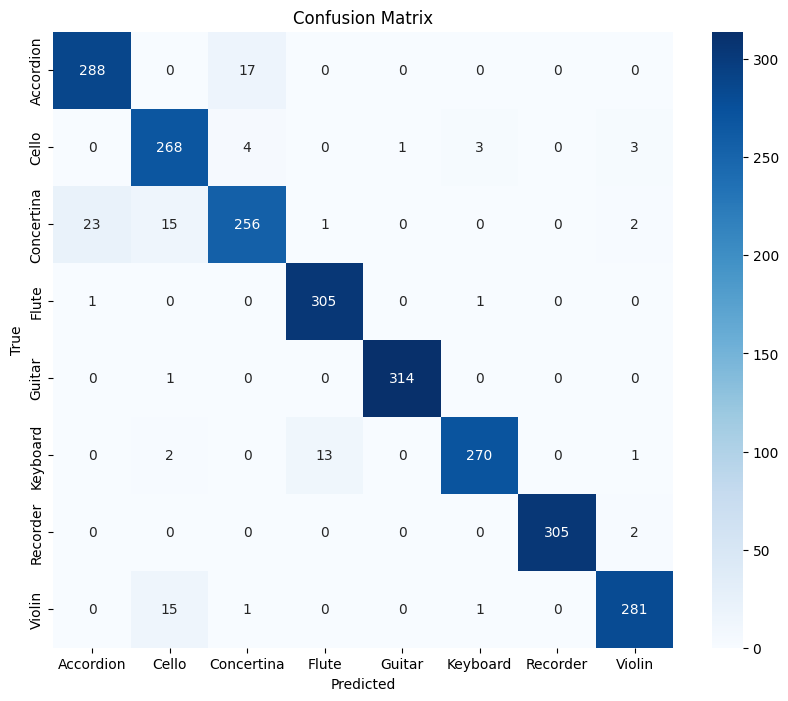

In [22]:
run_workflow(data, window_size=100, step_size=50)